# 如何解决overfitting？
1. more complete training data (not always possible).
2. techniques like regularization. 

So, in this file we will introduce some common regularition techniques.

In [2]:
import tensorflow as tf
# regularition from keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
# wtf? why delete a directory tree? 
shutil.rmtree(logdir, ignore_errors=True)

2.2.0-rc4


In [3]:
# download dataset: Higgs Dataset: 
# size: 11,000,000 instances
#       28         features
#       binary     labels
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')
FEATURES = 28

2816409600/2816407858 [==============================] - 48s 0us/step


In [0]:
# CsvDataset can be used to read csv records directly from a gzip file with no intermediate decompression step.
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

In [0]:
# That csv reader class returns a list of scalars for each record. 
# The following function repacks that list of scalars into a (feature_vector, label) pair.
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

Tensorflow 在处理大规模的batch时候效率很高。

所以可以直接从大型batch上调用pack_row function，这样效率比一条条调用pack_row要快。


In [0]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

packed_ds 就是一个feature list + label的组合
（feature_list, label） where feature_list contains 28 feature scalars.

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


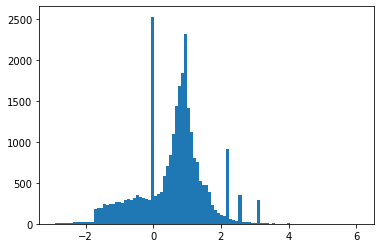

In [8]:
# 展示第一条数据的内容
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

In [0]:
# 前1000作为验证集，接下来10 000做训练集
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
# 这个Step—per-epoch是 训练集数量/batch size，它有什么用？
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

# Dataset.take, Dataset.skip 
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)


在深度学习中，一个模型中被用来学习的参数（可以通过训练修改的参数）被称为‘capacity’（容量）。
从小参数数量模型开始训练是避免过拟合不错的办法。

# Training Procedure

In [0]:
# We can use 'optimizers.schedules' to reduce the learning rate over time.
# ***** 可算知道怎么随着训练降低learning rate了
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    #  
    decay_steps = STEPS_PER_EPOCH * 1000,
    decay_rate = 1,
    staircase = False
)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

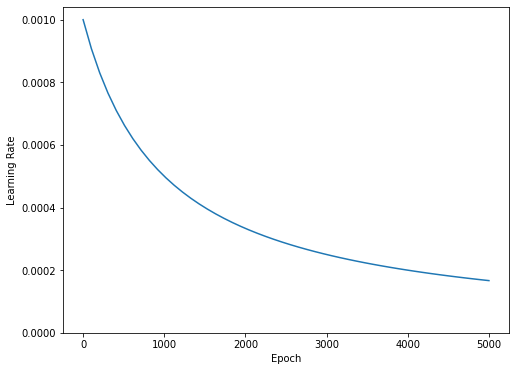

In [13]:
# show the learning relationship between the epochs and learning rate.
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')


In [0]:
# callback? contains some training configuration. 

def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

1. EpochDots：
  The training runs for many short epochs. To reduce the logging noise use the tfdocs.EpochDots which simply prints a . for each epoch, and a full set of metrics every 100 epochs.
2. callbacks.EarlyStopping avoids long and unnecessary training times. 
3. Use callbacks.TensorBoard to generate TensorBoard logs for the training.


In [0]:
# model configuration
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

# 从小到大规模训练模型

In [26]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])
# size_histories is a dictionary.
size_histories = {}
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4846,  binary_crossentropy:0.8263,  loss:0.8263,  val_accuracy:0.4700,  val_binary_crossentropy:0.7830,  val_loss:0.7830,  
....................................................................................................
Epoch: 100, accuracy:0.5934,  binary_crossentropy:0.6293,  loss:0.6293,  val_accuracy:0.5660,  val_binary_crossentropy:0.6363,  val_loss:0.6363,  
....................................................................................................
Epoch: 200, accuracy:0.

(0.5, 0.7)

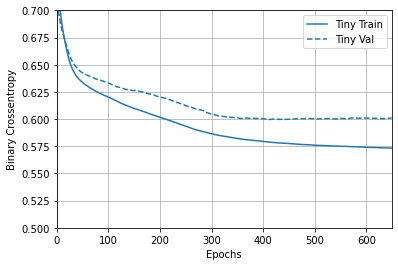

In [24]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

In [25]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small') 

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4731,  binary_crossentropy:0.7869,  loss:0.7869,  val_accuracy:0.4680,  val_binary_crossentropy:0.7448,  val_loss:0.7448,  
....................................................................................................
Epoch: 100, accuracy:0.6373,  binary_crossentropy:0.6037,  loss:0.6037,  val_accuracy:0.6460,  val_binary_crossentropy:0.6072,  val_loss:0.

In [27]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 64)                1856      
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4802,  binary_crossentropy:0.6974,  loss:0.6974,  val_accuracy:0.4840,  val_binary_crossentropy:0.6821,  val_loss:0.6821,  
....................................................................................................
E

In [28]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_18 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5114,  binary_crossentropy:0.7537,  loss:0.7537,  val_accuracy:0.4890,  val_binary_crossentr

Text(0.5, 0, 'Epochs [Log Scale]')

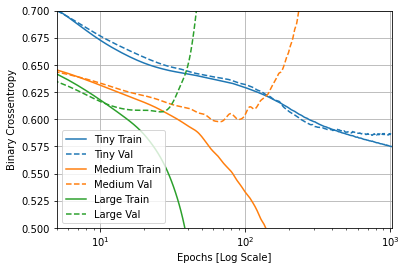

In [29]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

In [0]:
! tensorboard --logdir {logdir}/sizes

In [32]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")